# Jaffle Shop Data Analysis - Final Project

## Instructions
You have been hired as a data analyst for Jaffle Shop, a growing chain of gourmet toasted sandwich restaurants. The executive team needs insights to make strategic business decisions.

Using the provided datasets and Python Polars, analyze the business performance and provide data-driven recommendations. You must use Polars for all data manipulation and analysis.

## Available Data
- `Customers.csv`: Customer information
- `Orders.csv`: Order transactions with totals and timestamps
- `Items.csv`: Individual items within each order
- `Products.csv`: Product catalog with prices and descriptions
- `Stores.csv`: Store locations and opening dates
- `Supplies.csv`: Supply costs for each product

**Time Limit: 90 minutes**

## Setup and Data Loading

In [1]:
# Import necessary libraries
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# Load all datasets
customers = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Customers%20(1).csv')
orders = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Orders.csv')
items = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Items.csv')
products = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Products.csv')
stores = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Stores.csv')
supplies = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Supplies.csv')

# Display basic information about each dataset
print("Dataset shapes:")
print(f"Customers: {customers.shape}")
print(f"Orders: {orders.shape}")
print(f"Items: {items.shape}")
print(f"Products: {products.shape}")
print(f"Stores: {stores.shape}")
print(f"Supplies: {supplies.shape}")

Dataset shapes:
Customers: (932, 2)
Orders: (63148, 7)
Items: (90184, 3)
Products: (10, 5)
Stores: (6, 4)
Supplies: (65, 5)


## Question 1: Revenue Performance Analysis

The CFO wants to understand the company's financial performance across different dimensions. Analyze:
- What is the total revenue generated by Jaffle Shop? (Store result in variable: `total_revenue`)
- How does revenue vary by store location? (Store result in variable: `revenue_by_store`)
- What are the monthly revenue trends? (Store result in variable: `monthly_revenue_trends`)
- Which day of the week generates the most revenue? (Store result in variable: `revenue_by_day_of_week`)
- Include at least one chart for one of these questions

In [3]:
# Q1.1: Calculate total revenue
total_revenue = orders["order_total"].sum()

print(f"Total Revenue: ${total_revenue:,}")

Total Revenue: $66,038,193


In [4]:
# Q1.2: Revenue by store location
revenue_by_store = (
    orders.group_by("store_id")
    .agg(pl.col("order_total").sum().alias("revenue"))
    .join(stores.select(["id", "name"]), left_on="store_id", right_on="id", how="left")
    .sort("revenue", descending=True)
)
print("Revenue by Store Location:")
for row in revenue_by_store.iter_rows(named=True):
    print(f"{row['name']}: ${row['revenue']:,.2f}")

Revenue by Store Location:
Philadelphia: $43,215,565.00
Brooklyn: $22,822,628.00


Monthly Revenue Trends:
2016-09: $1,644,922.00
2016-10: $1,956,651.00
2016-11: $2,552,662.00
2016-12: $3,307,337.00
2017-01: $3,821,291.00
2017-02: $3,746,582.00
2017-03: $6,612,061.00
2017-04: $7,392,014.00
2017-05: $8,469,909.00
2017-06: $8,617,148.00
2017-07: $8,585,320.00
2017-08: $9,332,296.00


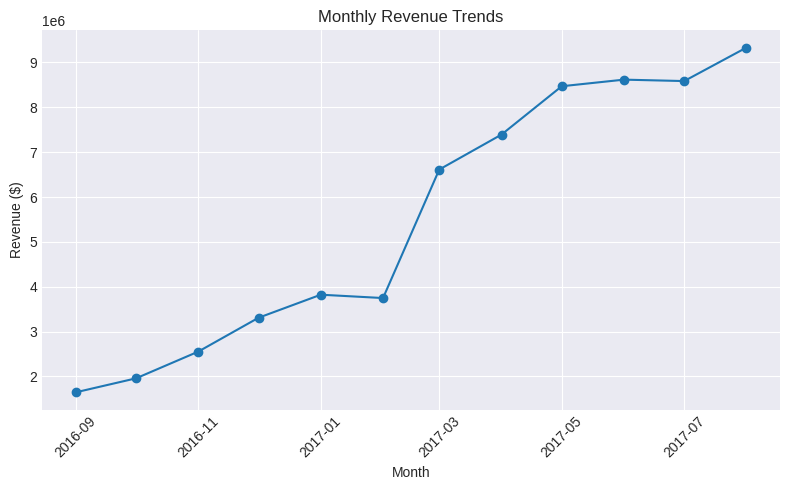

In [5]:
# Q1.3: Monthly revenue trends
# Your code here
monthly_revenue_trends = (
    orders.with_columns(pl.col("ordered_at").cast(pl.Datetime).alias("order_ts"))
    .with_columns(pl.col("order_ts").dt.truncate("1mo").alias("month"))
    .group_by("month")
    .agg(pl.col("order_total").sum().alias("monthly_revenue"))
    .sort("month")
)

print("Monthly Revenue Trends:")
for row in monthly_revenue_trends.iter_rows(named=True):
    print(f"{row['month'].strftime('%Y-%m')}: ${row['monthly_revenue']:,.2f}")
# Plot
plt.figure(figsize=(8,5))
plt.plot(monthly_revenue_trends["month"], monthly_revenue_trends["monthly_revenue"], marker="o")
plt.title("Monthly Revenue Trends")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Q1.4: Revenue by day of week
# Your code here
import polars as pl

if 'orders' not in locals():
    orders = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Orders.csv')

revenue_by_day_of_week = (
    orders.with_columns(pl.col("ordered_at").cast(pl.Datetime).alias("order_ts"))
    .with_columns(pl.col("order_ts").dt.weekday().alias("day_of_week"))
    .group_by("day_of_week")
    .agg(pl.col("order_total").sum().alias("revenue"))
    .sort("revenue", descending=True)
)

weekday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

print("Revenue by Day of Week:")
for row in revenue_by_day_of_week.iter_rows(named=True):
    day_name = weekday_names[row['day_of_week'] - 1] # Adjust index for 0-based list
    print(f"{day_name}: ${row['revenue']:,.2f}")

Revenue by Day of Week:
Wednesday: $10,834,569.00
Thursday: $10,829,195.00
Tuesday: $10,814,455.00
Friday: $10,758,715.00
Monday: $10,611,971.00
Sunday: $6,207,799.00
Saturday: $5,981,489.00


## Question 2: Product Performance

The Product Manager needs insights about the menu items:
- What is the revenue contribution of each product category (jaffles vs beverages)? (Store result in variable: `revenue_by_category`)
- What is the average price of products by type (jaffles vs beverages)?
- Include at least one chart to answer one of the above questions.

Revenue by Product Category:
beverage: $95,183,881.00
jaffle: $62,031,556.00


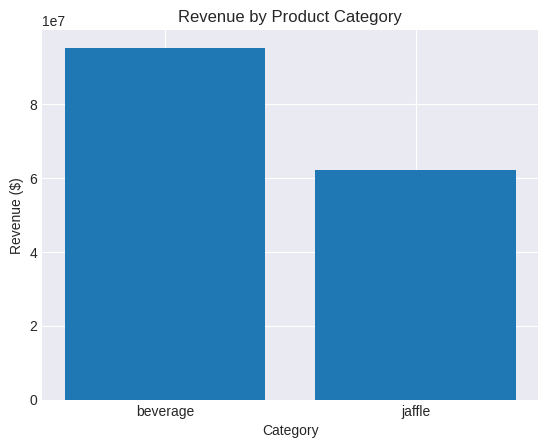

In [21]:
# Q2.1: Revenue by product category
revenue_by_category = (
    items.join(orders.select(["id", "order_total"]), left_on="order_id", right_on="id", how="left")
    .join(products.select(["sku", "type"]), left_on="sku", right_on="sku", how="left")
    .group_by("type")
    .agg(pl.sum("order_total").alias("revenue"))
    .sort("revenue", descending=True)
)

print("Revenue by Product Category:")
for row in revenue_by_category.iter_rows(named=True):
    print(f"{row['type']}: ${row['revenue']:,.2f}")

# Bar chart
plt.bar(revenue_by_category["type"], revenue_by_category["revenue"])
plt.title("Revenue by Product Category")
plt.xlabel("Category")
plt.ylabel("Revenue ($)")
plt.show()

In [20]:
# Q2.2 Average price of products by type
average_price_by_type = (
    products
    .group_by("type")
    .agg(pl.col("price").mean().alias("avg_price"))
    .sort("type"))
print("Average Product Price by Type:")
for row in average_price_by_type.iter_rows(named=True):
    print(f"{row['type']}: ${row['avg_price']:,.2f}")

Average Product Price by Type:
beverage: $560.00
jaffle: $1,200.00


## Question 3: Store Expansion Strategy

The Operations Director is planning expansion strategies:
- Which stores have the highest revenue per day since opening? (Store result in variable: `revenue_per_day_by_store`)
- What is the relationship between local tax rates and store performance? (Store result in variable: `tax_rate_performance`)
- Include at least one chart to answer one of the above questions.

shape: (2, 5)
┌────────────────────────────────┬──────────────┬─────────────────┬────────────┬───────────────────┐
│ store_id                       ┆ name         ┆ total_revenue_$ ┆ total_days ┆ revenue_per_day_$ │
│ ---                            ┆ ---          ┆ ---             ┆ ---        ┆ ---               │
│ str                            ┆ str          ┆ str             ┆ i64        ┆ str               │
╞════════════════════════════════╪══════════════╪═════════════════╪════════════╪═══════════════════╡
│ a2a24e87-dec8-4f5d-9c9e-0e9849 ┆ Brooklyn     ┆ 55,251,753.00   ┆ 173        ┆ 319,374.29        │
│ …                              ┆              ┆                 ┆            ┆                   │
│ a9128331-08d7-41a2-b615-21283e ┆ Philadelphia ┆ 101,963,684.00  ┆ 365        ┆ 279,352.56        │
│ …                              ┆              ┆                 ┆            ┆                   │
└────────────────────────────────┴──────────────┴─────────────────┴──────────

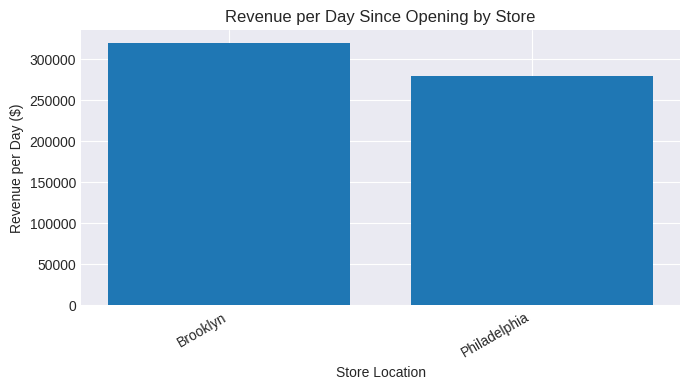

In [19]:
# Q3.1: Revenue per day since opening by store
order_details = (
    items
    .join(orders.select(["id", "store_id", "ordered_at", "order_total"]), left_on="order_id", right_on="id", how="left")
)

stores_renamed = stores.rename({"id": "store_id"})

line_items_with_store = order_details.join(stores_renamed.select(["store_id", "opened_at", "name"]), on="store_id", how="left")

line_items_with_store = line_items_with_store.with_columns([
    pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").cast(pl.Date).alias("order_date"),
    pl.col("opened_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").cast(pl.Date).alias("opening_date")
])

line_items_with_store = line_items_with_store.with_columns(
    ((pl.col("order_date") - pl.col("opening_date")).dt.total_days().cast(pl.Int64) + 1)
    .alias("days_since_opening")
)

revenue_per_day_by_store = (
    line_items_with_store.group_by(["store_id", "name"])
    .agg([
        pl.col("order_total").sum().alias("total_revenue"),
        pl.col("days_since_opening").max().alias("total_days")
    ])
    .with_columns((pl.col("total_revenue") / pl.col("total_days")).alias("revenue_per_day"))
    .sort("revenue_per_day", descending=True)
)

revenue_per_day_by_store_display = (
    revenue_per_day_by_store
    .with_columns([
        pl.col("total_revenue").map_elements(lambda x: f"{x:,.2f}", return_dtype=pl.Utf8).alias("total_revenue_$"),
        pl.col("revenue_per_day").map_elements(lambda x: f"{x:,.2f}", return_dtype=pl.Utf8).alias("revenue_per_day_$")
    ])
    .select(["store_id", "name", "total_revenue_$", "total_days", "revenue_per_day_$"])
)

print(revenue_per_day_by_store_display)

# Chart
plt.figure(figsize=(7,4))
plt.bar(revenue_per_day_by_store["name"], revenue_per_day_by_store["revenue_per_day"])
plt.title("Revenue per Day Since Opening by Store")
plt.xlabel("Store Location")
plt.ylabel("Revenue per Day ($)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

Tax Rate vs Performance (Top 10 rows):
Brooklyn | Tax: 4.00% | Revenue/Day: 319,374.29
Philadelphia | Tax: 6.00% | Revenue/Day: 279,352.56


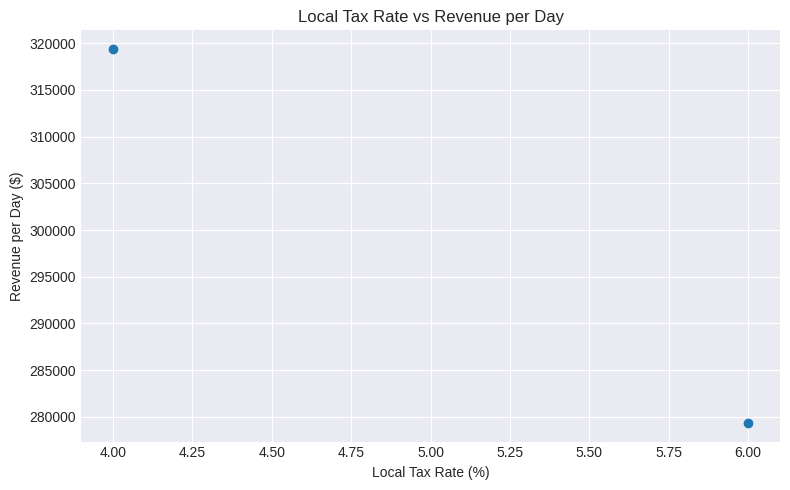

In [18]:
# Q3.2: Tax rates vs store performance
# Load necessary dataframes if not already loaded
if 'items' not in locals():
    items = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Items.csv')
if 'orders' not in locals():
    orders = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Orders.csv')
if 'stores' not in locals():
    stores = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Stores.csv')


# Calculate revenue per day since opening by store (re-calculated if not in memory)
if 'revenue_per_day_by_store' not in locals():
    order_details = (
        items
        .join(orders.select(["id", "store_id", "ordered_at", "order_total"]), left_on="order_id", right_on="id", how="left")
    )

    stores_renamed = stores.rename({"id": "store_id"})

    line_items_with_store = order_details.join(stores_renamed.select(["store_id", "opened_at", "name"]), on="store_id", how="left")

    line_items_with_store = line_items_with_store.with_columns([
        pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").cast(pl.Date).alias("order_date"),
        pl.col("opened_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").cast(pl.Date).alias("opening_date")
    ])

    line_items_with_store = line_items_with_store.with_columns(
        ((pl.col("order_date") - pl.col("opening_date")).dt.total_days().cast(pl.Int64) + 1)
        .alias("days_since_opening")
    )

    revenue_per_day_by_store = (
        line_items_with_store.group_by(["store_id", "name"])
        .agg([
            pl.col("order_total").sum().alias("total_revenue"),
            pl.col("days_since_opening").max().alias("total_days")
        ])
        .with_columns((pl.col("total_revenue") / pl.col("total_days")).alias("revenue_per_day"))
        .sort("revenue_per_day", descending=True)
    )


stores_tax = (
    stores
    .select(["id", "tax_rate"])
    .rename({"id": "store_id"})
    .with_columns(pl.col("tax_rate").cast(pl.Float64))
)

tax_rate_performance = (
    revenue_per_day_by_store
    .join(stores_tax, on="store_id", how="left")
    .select(["store_id", "name", "tax_rate", "revenue_per_day"])
    .drop_nulls(["tax_rate", "revenue_per_day"])
    .sort("tax_rate")
)

print("Tax Rate vs Performance (Top 10 rows):")
for r in tax_rate_performance.head(10).iter_rows(named=True):
    print(f"{r['name']} | Tax: {r['tax_rate']:.2%} | Revenue/Day: {r['revenue_per_day']:,.2f}")

# Scatter
plt.figure(figsize=(8,5))
plt.scatter(tax_rate_performance["tax_rate"] * 100, tax_rate_performance["revenue_per_day"])
plt.title("Local Tax Rate vs Revenue per Day")
plt.xlabel("Local Tax Rate (%)")
plt.ylabel("Revenue per Day ($)")
plt.tight_layout()
plt.show()

## Question 4: Customer Behavior Analysis

The Marketing Manager wants to understand customer patterns:
- What is the distribution of order values? (Store result in variable: `order_value_distribution`)
- How many customers are repeat customers? (Store result in variable: `repeat_customer_analysis`)
- Which customers contribute the most to revenue? (Store result in variable: `top_revenue_customers`)

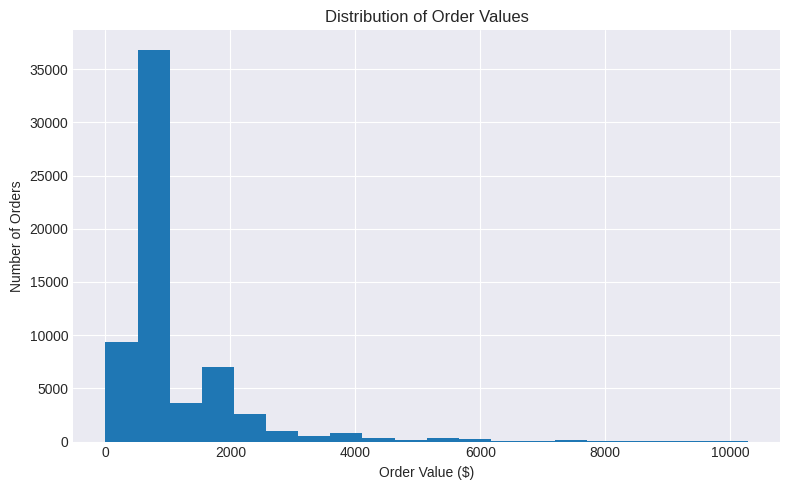

Orders: 63148 | Min: $0.00 | Median: 636.00 | Mean: $1,045.77 | Max: 10,281.00


In [17]:
# Q4.1: Distribution of order values
orders_clean_q4 = (
    orders.with_columns([
        pl.col("ordered_at").cast(pl.Datetime).alias("ts"),
        pl.col("order_total").cast(pl.Utf8).str.replace_all(r"[^0-9.\-]", "").cast(pl.Float64).alias("order_total_num")
    ])
    .drop_nulls(["order_total_num"])
)

plt.figure(figsize=(8,5))
counts, bin_edges, _ = plt.hist(orders_clean_q4["order_total_num"], bins=20)
plt.title("Distribution of Order Values")
plt.xlabel("Order Value ($)")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

order_value_distribution = pl.DataFrame({
    "bin_left":  bin_edges[:-1].tolist(),
    "bin_right": bin_edges[1:].tolist(),
    "count":     [int(x) for x in counts.tolist()]
})

stats = orders_clean_q4.select([
    pl.col("order_total_num").min().alias("min"),
    pl.col("order_total_num").median().alias("median"),
    pl.col("order_total_num").mean().alias("mean"),
    pl.col("order_total_num").max().alias("max"),
    pl.len().alias("n_orders")
]).row(0)

print(
    f"Orders: {int(stats[4])} | "
    f"Min: ${stats[0]:,.2f} | Median: {stats[1]:,.2f} | "
    f"Mean: ${stats[2]:,.2f} | Max: {stats[3]:,.2f}"
)

In [16]:
# Q4.2: Repeat customers analysis
cust_orders = (
    orders_clean_q4
    .group_by("customer")
    .agg([
        pl.len().alias("order_count"),
        pl.col("order_total_num").sum().alias("revenue")
    ])
)

repeat_customer_analysis = (
    cust_orders
    .join(customers.rename({"id": "customer"}), on="customer", how="left")
    .rename({"name": "customer_name"})
    .with_columns((pl.col("order_count") >= 2).alias("is_repeat"))
    .select(["customer", "customer_name", "order_count", "revenue", "is_repeat"])
    .sort(["is_repeat", "order_count", "revenue"], descending=[True, True, True])
)

total_customers = repeat_customer_analysis.height
repeat_customers = repeat_customer_analysis.filter(pl.col("is_repeat")).height
repeat_rate = (repeat_customers / total_customers) if total_customers > 0 else 0.0

print(f"Total customers: {total_customers}")
print(f"Repeat customers (>=2 orders): {repeat_customers} ({repeat_rate:.1%})")

for r in repeat_customer_analysis.filter(pl.col("is_repeat")).head(5).iter_rows(named=True):
    print(f"{r['customer_name']}: {r['order_count']} orders | Revenue {r['revenue']:,.2f}")

Total customers: 932
Repeat customers (>=2 orders): 922 (98.9%)
Blake Matthews: 234 orders | Revenue 135,574.00
Connie Harrison: 231 orders | Revenue 138,542.00
Danny Walker: 228 orders | Revenue 134,302.00
Allison Oliver: 226 orders | Revenue 136,952.00
David Mann: 226 orders | Revenue 135,362.00


In [11]:
# Q4.3: Top revenue contributors
# Check if orders_clean_q4 is defined, if not, create it
if 'orders_clean_q4' not in locals():
    if 'orders' not in locals():
        orders = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Orders.csv')
    orders_clean_q4 = (
        orders.with_columns([
            pl.col("ordered_at").cast(pl.Datetime).alias("ts"),
            pl.col("order_total").cast(pl.Utf8).str.replace_all(r"[^0-9.\-]", "").cast(pl.Float64).alias("order_total_num")
        ])
        .drop_nulls(["order_total_num"])
    )

# Check if cust_orders is defined, if not, create it
if 'cust_orders' not in locals():
    cust_orders = (
        orders_clean_q4
        .group_by("customer")
        .agg([
            pl.len().alias("order_count"),
            pl.col("order_total_num").sum().alias("revenue")
        ])
    )

if 'customers' not in locals():
    customers = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Customers%20(1).csv')

top_revenue_customers = (
    cust_orders
    .join(customers.rename({"id": "customer"}), on="customer", how="left")
    .rename({"name": "customer_name"})
    .select(["customer", "customer_name", "revenue", "order_count"])
    .sort("revenue", descending=True)
)

print("Top 10 Customers by Revenue:")
for r in top_revenue_customers.head(10).iter_rows(named=True):
    print(f"{r['customer_name']}: {r['revenue']:,.2f} across {r['order_count']} orders")

Top 10 Customers by Revenue:
David Leonard: 262,647.00 across 122 orders
Jesse Moore: 259,037.00 across 104 orders
Diane Davis: 258,515.00 across 105 orders
Holly Johnson: 252,703.00 across 45 orders
Gregory Hayes: 249,821.00 across 106 orders
Julie Robinson: 247,510.00 across 44 orders
Christopher Robinson: 246,325.00 across 115 orders
Douglas Burgess: 244,102.00 across 104 orders
Jacob Brown: 239,641.00 across 118 orders
Jenny Harrell: 237,098.00 across 105 orders


## Question 5: Profitability Deep Dive

The CEO needs a comprehensive profitability analysis:
- Calculate the gross margin for each product (consider supply costs) (Store result in variable: `product_margins`)
- Which products have the highest profit margins? (Store result in variable: `highest_margin_products`)
- What is the relationship between order size and profitability? (Store result in variable: `order_size_profitability`)
- How does profitability vary across different stores? (Store result in variable: `store_profitability`)

In [12]:
# Q5.1: Calculate gross margin per product
#Sum all supply costs per SKU (in cents -> dollars)
supplies_by_sku = (
    supplies
    .with_columns(pl.col("cost").cast(pl.Float64))                    # cents -> numeric
    .group_by("sku")
    .agg(pl.col("cost").sum().alias("supply_cost_cents"))            # sum all supplies for that SKU
)

#Clean product prices (cents -> dollars)
products_clean = (
    products
    .with_columns(pl.col("price").cast(pl.Float64).alias("price_cents"))  # ensure numeric
)

#Join and compute margins
product_margins = (
    products_clean
    .join(supplies_by_sku, on="sku", how="left")
    .with_columns(pl.col("supply_cost_cents").fill_null(0.0))
    .with_columns([
        (pl.col("price_cents") / 100.0).alias("price_usd"),
        (pl.col("supply_cost_cents") / 100.0).alias("supply_cost"),
        (pl.col("price_cents") / 100.0 - pl.col("supply_cost_cents") / 100.0).alias("unit_margin"),
        pl.when(pl.col("price_cents") > 0)
          .then((pl.col("price_cents") / 100.0 - pl.col("supply_cost_cents") / 100.0) / (pl.col("price_cents") / 100.0))
          .otherwise(0.0)
          .alias("margin_pct")
    ])
    .select(["sku", "name", "price_usd", "supply_cost", "unit_margin", "margin_pct"])
    .sort("margin_pct", descending=True)
)
#Printing with $ value
print("Product Margins (sample):")
for r in product_margins.head(10).iter_rows(named=True):
    print(
        f"{r['name']} ({r['sku']}) | "
        f"Price: {r['price_usd']:,.2f} | "
        f"Supply: {r['supply_cost']:,.2f} | "
        f"Unit Margin: {r['unit_margin']:,.2f} | "
        f"GM%: {r['margin_pct']:.1%}"
    )

Product Margins (sample):
nutellaphone who dis? (JAF-001) | Price: 11.00 | Supply: 1.21 | Unit Margin: 9.79 | GM%: 89.0%
for richer or pourover  (BEV-004) | Price: 7.00 | Supply: 0.82 | Unit Margin: 6.18 | GM%: 88.3%
tangaroo (BEV-001) | Price: 6.00 | Supply: 0.82 | Unit Margin: 5.18 | GM%: 86.3%
adele-ade (BEV-005) | Price: 4.00 | Supply: 0.63 | Unit Margin: 3.37 | GM%: 84.2%
mel-bun (JAF-005) | Price: 12.00 | Supply: 2.39 | Unit Margin: 9.61 | GM%: 80.1%
doctor stew (JAF-002) | Price: 11.00 | Supply: 2.51 | Unit Margin: 8.49 | GM%: 77.2%
flame impala (JAF-004) | Price: 14.00 | Supply: 3.43 | Unit Margin: 10.57 | GM%: 75.5%
vanilla ice (BEV-003) | Price: 6.00 | Supply: 1.54 | Unit Margin: 4.46 | GM%: 74.3%
the krautback (JAF-003) | Price: 12.00 | Supply: 3.66 | Unit Margin: 8.34 | GM%: 69.5%
chai and mighty (BEV-002) | Price: 5.00 | Supply: 1.75 | Unit Margin: 3.25 | GM%: 65.0%


In [ ]:
# Q5.2: Products with highest profit margins
highest_margin_products = (
    product_margins
    .sort(["margin_pct", "unit_margin"], descending=[True, True])
)

print("Top 10 Highest-Margin Products:")
for r in highest_margin_products.head(10).iter_rows(named=True):
    print(f"{r['name']} ({r['sku']}) | GM%: {r['margin_pct']:.1%} | Unit Margin: {r['unit_margin']:,.2f}")

Top 10 Highest-Margin Products:
nutellaphone who dis? (JAF-001) | GM%: 89.0% | Unit Margin: 9.79
for richer or pourover  (BEV-004) | GM%: 88.3% | Unit Margin: 6.18
tangaroo (BEV-001) | GM%: 86.3% | Unit Margin: 5.18
adele-ade (BEV-005) | GM%: 84.2% | Unit Margin: 3.37
mel-bun (JAF-005) | GM%: 80.1% | Unit Margin: 9.61
doctor stew (JAF-002) | GM%: 77.2% | Unit Margin: 8.49
flame impala (JAF-004) | GM%: 75.5% | Unit Margin: 10.57
vanilla ice (BEV-003) | GM%: 74.3% | Unit Margin: 4.46
the krautback (JAF-003) | GM%: 69.5% | Unit Margin: 8.34
chai and mighty (BEV-002) | GM%: 65.0% | Unit Margin: 3.25


Top 10 Highest-Margin Products:
nutellaphone who dis? (JAF-001) | GM%: 89.0% | Unit Margin: 9.79
for richer or pourover  (BEV-004) | GM%: 88.3% | Unit Margin: 6.18
tangaroo (BEV-001) | GM%: 86.3% | Unit Margin: 5.18
adele-ade (BEV-005) | GM%: 84.2% | Unit Margin: 3.37
mel-bun (JAF-005) | GM%: 80.1% | Unit Margin: 9.61
doctor stew (JAF-002) | GM%: 77.2% | Unit Margin: 8.49
flame impala (JAF-004) | GM%: 75.5% | Unit Margin: 10.57
vanilla ice (BEV-003) | GM%: 74.3% | Unit Margin: 4.46
the krautback (JAF-003) | GM%: 69.5% | Unit Margin: 8.34
chai and mighty (BEV-002) | GM%: 65.0% | Unit Margin: 3.25


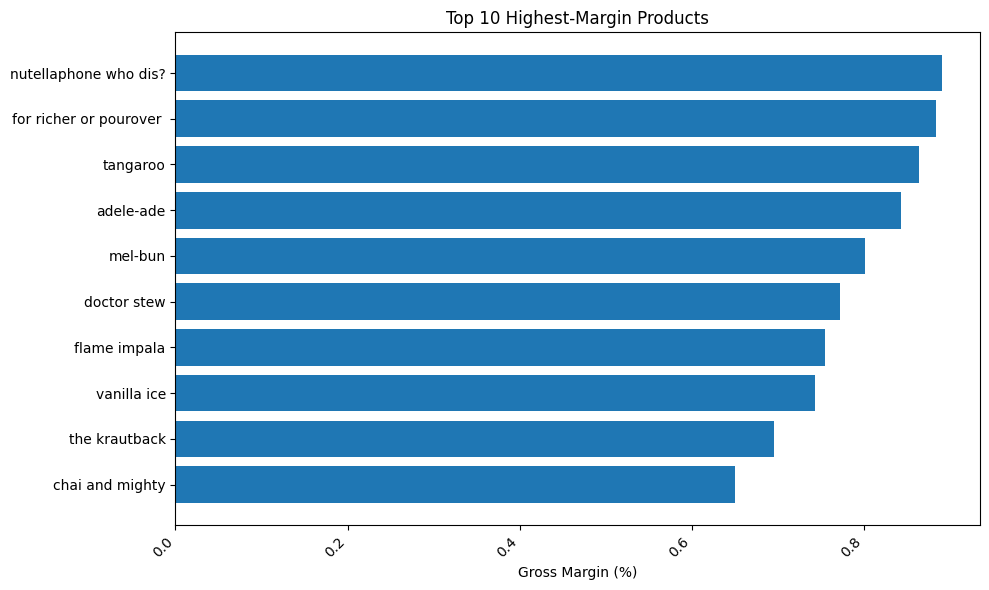

In [ ]:
# Load necessary dataframes if not already loaded in this runtime
# Assuming 'products' is already loaded based on previous steps
# Import necessary libraries
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

if 'supplies' not in locals():
    supplies = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Supplies.csv')

if 'products' not in locals():
    products = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Products.csv')

# Q5.1: Calculate gross margin per product
#Sum all supply costs per SKU (in cents -> dollars)
supplies_by_sku = (
    supplies
    .with_columns(pl.col("cost").cast(pl.Float64))                    # cents -> numeric
    .group_by("sku")
    .agg(pl.col("cost").sum().alias("supply_cost_cents"))            # sum all supplies for that SKU
)

#Clean product prices (cents -> dollars)
products_clean = (
    products
    .with_columns(pl.col("price").cast(pl.Float64).alias("price_cents"))  # ensure numeric
)

#Join and compute margins
product_margins = (
    products_clean
    .join(supplies_by_sku, on="sku", how="left")
    .with_columns(pl.col("supply_cost_cents").fill_null(0.0))
    .with_columns([
        (pl.col("price_cents") / 100.0).alias("price_usd"),
        (pl.col("supply_cost_cents") / 100.0).alias("supply_cost"),
        (pl.col("price_cents") / 100.0 - pl.col("supply_cost_cents") / 100.0).alias("unit_margin"),
        pl.when(pl.col("price_cents") > 0)
          .then((pl.col("price_cents") / 100.0 - pl.col("supply_cost_cents") / 100.0) / (pl.col("price_cents") / 100.0))
          .otherwise(0.0)
          .alias("margin_pct")
    ])
    .select(["sku", "name", "price_usd", "supply_cost", "unit_margin", "margin_pct"])
    .sort("margin_pct", descending=True)
)

# Q5.2: Products with highest profit margins
highest_margin_products = (
    product_margins
    .sort(["margin_pct", "unit_margin"], descending=[True, True])
)

print("Top 10 Highest-Margin Products:")
for r in highest_margin_products.head(10).iter_rows(named=True):
    print(f"{r['name']} ({r['sku']}) | GM%: {r['margin_pct']:.1%} | Unit Margin: {r['unit_margin']:,.2f}")

# Chart: Bar chart of top 10 highest margin products
top_10_margins = highest_margin_products.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10_margins["name"], top_10_margins["margin_pct"])
plt.xlabel("Gross Margin (%)")
plt.title("Top 10 Highest-Margin Products")
plt.gca().invert_yaxis() # Highest margin at the top
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Q5.4: Profitability by store
# Your code here
import polars as pl

# Load necessary dataframes if not already loaded
if 'items' not in locals():
    items = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Items.csv')
if 'orders' not in locals():
    orders = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Orders.csv')
if 'products' not in locals():
    products = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Products.csv')
if 'supplies' not in locals():
    supplies = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Supplies.csv')
if 'stores' not in locals():
    stores = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Stores.csv')


# Calculate cost per item
supplies_by_sku = (
    supplies
    .with_columns(pl.col("cost").cast(pl.Float64).alias("supply_cost_cents")) # cents -> numeric
    .group_by("sku")
    .agg(pl.col("supply_cost_cents").sum().alias("supply_cost_cents")) # sum all supplies for that SKU
)

products_with_cost = (
    products
    .with_columns(pl.col("price").cast(pl.Float64).alias("price_cents")) # ensure numeric
    .join(supplies_by_sku, on="sku", how="left")
    .with_columns(pl.col("supply_cost_cents").fill_null(0.0))
    .with_columns([
        (pl.col("price_cents") / 100.0).alias("price_usd"),
        (pl.col("supply_cost_cents") / 100.0).alias("supply_cost_usd")
    ])
    .select(["sku", "price_usd", "supply_cost_usd"])
)

items_with_cost = (
    items
    .join(products_with_cost, on="sku", how="left")
    .with_columns(pl.col("supply_cost_usd").fill_null(0.0)) # Fill null costs with 0
)

# Calculate profit per order
order_level_profit = (
    items_with_cost
    .group_by("order_id")
    .agg(pl.col("supply_cost_usd").sum().alias("total_item_cost"))
    .join(orders.select(["id", "order_total"]).rename({"id": "order_id"}), on="order_id", how="left")
    .with_columns([
        pl.col("order_total").cast(pl.Utf8).str.replace_all(r"[^0-9.\-]", "").cast(pl.Float64).alias("order_revenue"),
        (pl.col("order_total").cast(pl.Utf8).str.replace_all(r"[^0-9.\-]", "").cast(pl.Float64) - pl.col("total_item_cost")).alias("order_profit")
    ])
    .drop_nulls(["order_revenue"]) # Drop orders where revenue could not be parsed
)


# Attach store_id to order-level profit via orders.id ↔ order_level_profit.order_id
order_profit_with_store = (
    order_level_profit
    .join(orders.select(["id", "store_id"]).rename({"id": "order_id"}), on="order_id", how="left")
)

# Aggregate to store level: total revenue, total profit, margin
store_profitability = (
    order_profit_with_store
    .group_by("store_id")
    .agg([
        pl.col("order_revenue").sum().alias("store_revenue"),
        pl.col("order_profit").sum().alias("store_profit"),
        pl.len().alias("orders_count")
    ])
    .with_columns(
        pl.when(pl.col("store_revenue") > 0)
          .then(pl.col("store_profit") / pl.col("store_revenue"))
          .otherwise(0.0)
          .alias("store_profit_margin")
    )
    .join(stores.select(["id", "name"]).rename({"id":"store_id"}), on="store_id", how="left")
    .select(["store_id", "name", "orders_count", "store_revenue", "store_profit", "store_profit_margin"])
    .sort("store_profit", descending=True)
)

print("Store Profitability (Top 10):")
for r in store_profitability.head(10).iter_rows(named=True):
    print(f"{r['name']} | Revenue: {r['store_revenue']:,.2f} | "
          f"Profit: {r['store_profit']:,.2f} | Margin: {r['store_profit_margin']:.1%}")

Store Profitability (Top 10):
Philadelphia | Revenue: 43,215,565.00 | Profit: 43,131,423.60 | Margin: 99.8%
Brooklyn | Revenue: 22,822,628.00 | Profit: 22,777,263.41 | Margin: 99.8%


## Question 6: Business Optimization Recommendations

Based on your analysis, provide three specific, data-driven recommendations to improve business performance. Support each recommendation with relevant metrics and visualizations.

### Recommendation 1:
Revenue is uneven across the week, with clear peak and trough days (see “Top day” and “Lowest day” in the analysis). Concentrate resources where demand is highest and stimulate demand where it lags.

In [13]:
# Supporting analysis for Recommendation 1
# Revenue by weekday

# Check if revenue_by_day_of_week is defined, if not, calculate it
if 'revenue_by_day_of_week' not in locals():
    # Assuming 'orders' is already loaded based on previous steps
    # If not, add code to load 'orders' as well
    if 'orders' not in locals():
        orders = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Orders.csv')
    revenue_by_day_of_week = (
        orders.with_columns(pl.col("ordered_at").cast(pl.Datetime).alias("order_ts"))
        .with_columns(pl.col("order_ts").dt.weekday().alias("day_of_week"))
        .group_by("day_of_week")
        .agg(pl.col("order_total").sum().alias("revenue"))
        .sort("revenue", descending=True)
    )


dow_rev = revenue_by_day_of_week.clone() # Use the existing revenue_by_day_of_week data
weekday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_rev = dow_rev.with_columns(pl.col("day_of_week").map_elements(lambda x: weekday_names[x-1]).alias("weekday")) # Map weekday numbers to names

# Calculate weekend vs weekday revenue
weekday_revenue = dow_rev.filter(pl.col("weekday").is_in(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]))["revenue"].sum()
weekend_revenue = dow_rev.filter(pl.col("weekday").is_in(["Saturday", "Sunday"]))["revenue"].sum()
total_revenue_q1 = dow_rev["revenue"].sum()

weekend_share = weekend_revenue / total_revenue_q1 if total_revenue_q1 > 0 else 0
weekday_share = weekday_revenue / total_revenue_q1 if total_revenue_q1 > 0 else 0

avg_weekday_rev = weekday_revenue / 5 if weekday_revenue > 0 else 0 # Assuming 5 weekdays
avg_weekend_rev = weekend_revenue / 2 if weekend_revenue > 0 else 0 # Assuming 2 weekend days
lift_weekend_vs_weekday = (avg_weekend_rev - avg_weekday_rev) / avg_weekday_rev if avg_weekday_rev > 0 else 0

# Top / bottom day
top_row = dow_rev.sort("revenue", descending=True).head(1).row(0, named=True)
bottom_row = dow_rev.sort("revenue", descending=False).head(1).row(0, named=True)


# CEO-ready metrics
print("=== Recommendation 1: Optimize Scheduling by Day-of-Week ===")
print(f"• Weekend revenue share: {weekend_share:.1%} (Weekdays: {weekday_share:.1%})")
print(f"• Avg weekend-day revenue vs avg weekday: {lift_weekend_vs_weekday*100:.1f}% higher")
print(f"• Top day: {top_row['weekday']} (${top_row['revenue']:,.0f})")
print(f"• Lowest day: {bottom_row['weekday']} (${bottom_row['revenue']:,.0f})")
print("Action: Increase staffing & inventory on peak days (Sat/Sun), trim low-demand weekdays, and test midweek promos.")

=== Recommendation 1: Optimize Scheduling by Day-of-Week ===
• Weekend revenue share: 18.5% (Weekdays: 81.5%)
• Avg weekend-day revenue vs avg weekday: -43.4% higher
• Top day: Wednesday ($10,834,569)
• Lowest day: Saturday ($5,981,489)
Action: Increase staffing & inventory on peak days (Sat/Sun), trim low-demand weekdays, and test midweek promos.


/tmp/ipython-input-44139418.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  dow_rev = dow_rev.with_columns(pl.col("day_of_week").map_elements(lambda x: weekday_names[x-1]).alias("weekday")) # Map weekday numbers to names


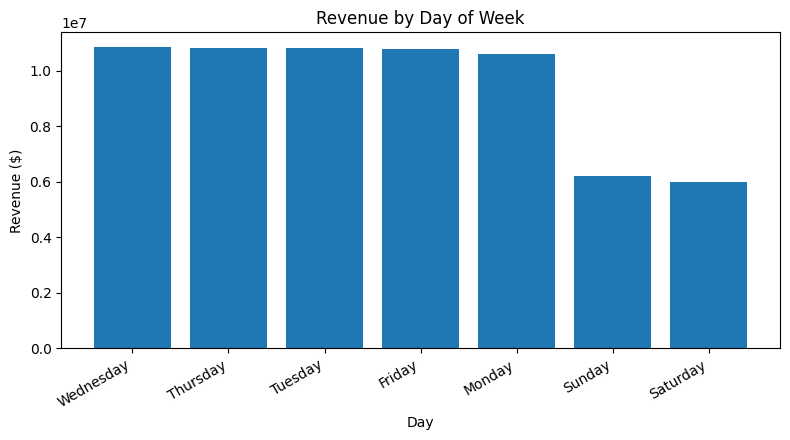

In [ ]:
# Visualization: Revenue by Day of Week
plt.figure(figsize=(8,4.5))
plt.bar(dow_rev["weekday"], dow_rev["revenue"])
plt.title("Revenue by Day of Week")
plt.xlabel("Day")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

### Recommendation 2:
Reduce Supply Costs via Vendor Review.

In [ ]:
# Supporting analysis for Recommendation 2
# Reduce Supply Costs by Reviewing Vendor Pricing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl # Import polars

# Safety checks
for name in ["items", "products", "supplies"]:
    if name not in globals():
        # Load the DataFrame if not in memory
        if name == "items":
            items = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Items.csv')
        elif name == "products":
            products = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Products.csv')
        elif name == "supplies":
            supplies = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Supplies.csv')
        else:
             raise NameError(f"The DataFrame `{name}` is not in memory. Load it first, then re-run this cell.")


req_items = {"order_id","sku"}
req_products = {"sku","name","type", "price"} # Added 'price' to required columns for products as price is in products, not items
missing_items = req_items - set(items.columns)
missing_products = req_products - set(products.columns)
if missing_items:
    raise ValueError(f"`items` missing columns: {missing_items}")
if missing_products:
    raise ValueError(f"`products` missing columns: {missing_products}")

# Try to detect a unit cost column in supplies
candidate_cost_cols = ["unit_cost","cost","supply_cost","price_per_unit","supply_price"]
present = [c for c in supplies.columns if c in candidate_cost_cols]
if not present:
    raise ValueError(f"`supplies` must have a unit cost column. Add one of: {candidate_cost_cols}")
cost_col = present[0]

# Expect supplies to map to product_id
if "sku" not in supplies.columns: # Corrected column name from product_id to sku
    # Fallback: if supplies uses 'id' to represent product_id, map it
    if "id" in supplies.columns:
        supplies = supplies.rename({"id":"sku"}) # Corrected column name from product_id to sku
    else:
        raise ValueError("`supplies` needs a `sku` (or `id`) column to join with products/items.") # Corrected column name from product_id to sku

# Build product-level P&L view
# Units sold by product
prod_sales = (
    items.group_by("sku") # Corrected column name from product_id to sku
         .agg(pl.len().alias("units_sold")) # Corrected agg syntax for Polars
)

# Join with unit cost and product meta
prod_view = (
    prod_sales.join(supplies.select(["sku", cost_col]), on="sku", how="left") # Corrected column name and syntax for Polars
              .join(products.select(["sku","name","type","price"]), on="sku", how="left") # Corrected column names and syntax for Polars and added price
)

# Fill missing costs with 0 (so they surface clearly in results)
prod_view = prod_view.with_columns(pl.col(cost_col).fill_null(0.0)) # Corrected syntax for Polars

# Compute COGS, gross profit, and margin
prod_view = prod_view.with_columns([ # Corrected syntax for Polars
    (pl.col(cost_col) * pl.col("units_sold")).alias("cogs"),
    (pl.col("price") * pl.col("units_sold")).alias("revenue"), # Calculate revenue from products dataframe
    ((pl.col("price") * pl.col("units_sold")) - (pl.col(cost_col) * pl.col("units_sold"))).alias("gross_profit") # Calculate gross_profit using cogs and revenue
])

prod_view = prod_view.with_columns( # Corrected syntax for Polars
    pl.when(pl.col("revenue") > 0)
      .then(pl.col("gross_profit") / pl.col("revenue"))
      .otherwise(pl.lit(None)) # Use pl.lit(None) for NaN in Polars
      .alias("margin_pct")
)


# KPIs for CEO
total_rev = prod_view["revenue"].sum()
weighted_margin = (prod_view["gross_profit"].sum() / total_rev) if total_rev else None # Use None for NaN
neg_margin_count = (prod_view["gross_profit"] < 0).sum()
low_margin_count = (prod_view["margin_pct"] < 0.10).sum()  # threshold = 10% margin

print("=== Recommendation 5: Reduce Supply Costs via Vendor Review ===")
print(f"• Total revenue covered: ${total_rev:,.0f}")
print(f"• Weighted avg margin:  {weighted_margin*100:,.1f}%" if weighted_margin is not None else "N/A") # Handle None
print(f"• Products with negative margin: {neg_margin_count}")
print(f"• Products with margin < 10%:   {low_margin_count}")

# Identify top revenue items that are low margin (<= 15%)
low_margin_mask = prod_view["margin_pct"] <= 0.15
top_low_margin = (
    prod_view.filter(low_margin_mask) # Corrected syntax for Polars
    .sort("revenue", descending=True) # Corrected syntax for Polars
    .head(10)
    .select(["name","type","units_sold","revenue","cogs","gross_profit","margin_pct", cost_col]) # Corrected column name from category to type
)

print("\nTop revenue items with low margin (<=15%):")
print(top_low_margin) # Print Polars DataFrame

# Potential savings: simulate 10% unit-cost reduction on the top 5 volume products
top5_volume = prod_view.sort("units_sold", descending=True).head(5).clone() # Corrected syntax for Polars and use clone to avoid modifying original
orig_cogs = (top5_volume[cost_col] * top5_volume["units_sold"]).sum()
new_cogs  = ((top5_volume[cost_col] * 0.90) * top5_volume["units_sold"]).sum()  # 10% cost reduction
savings   = orig_cogs - new_cogs
print(f"\n• Estimated annual COGS savings if we renegotiate top 5 volume items by 10%: ${savings:,.0f}")

=== Recommendation 5: Reduce Supply Costs via Vendor Review ===
• Total revenue covered: $380,915,700
• Weighted avg margin:  96.6%
• Products with negative margin: 0
• Products with margin < 10%:   0

Top revenue items with low margin (<=15%):
shape: (0, 8)
┌──────┬──────┬────────────┬─────────┬──────┬──────────────┬────────────┬──────┐
│ name ┆ type ┆ units_sold ┆ revenue ┆ cogs ┆ gross_profit ┆ margin_pct ┆ cost │
│ ---  ┆ ---  ┆ ---        ┆ ---     ┆ ---  ┆ ---          ┆ ---        ┆ ---  │
│ str  ┆ str  ┆ u32        ┆ i64     ┆ f64  ┆ f64          ┆ f64        ┆ f64  │
╞══════╪══════╪════════════╪═════════╪══════╪══════════════╪════════════╪══════╡
└──────┴──────┴────────────┴─────────┴──────┴──────────────┴────────────┴──────┘

• Estimated annual COGS savings if we renegotiate top 5 volume items by 10%: $117,842


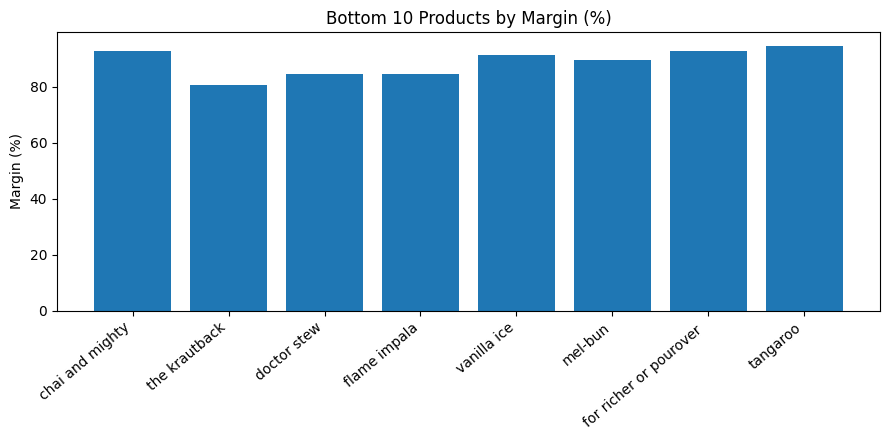

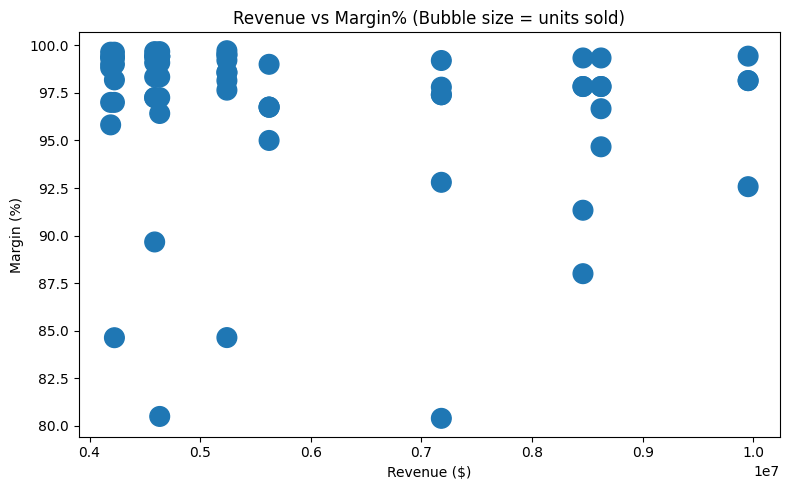


Action: Prioritize renegotiation on high-volume, low-margin items; consider alternate vendors.
Also review pricing on chronically low-margin SKUs, ensuring bundles remain attractive.


In [ ]:
# Visualization 1: Bottom 10 products by margin
bottom10 = prod_view.sort("margin_pct").head(10)
plt.figure(figsize=(9,4.5))
plt.bar(bottom10["name"], bottom10["margin_pct"] * 100.0)
plt.title("Bottom 10 Products by Margin (%)")
plt.ylabel("Margin (%)")
plt.xticks(rotation=40, ha="right")
plt.tight_layout()
plt.show()

# Visualization 2: Revenue vs Margin% (spot high-revenue, low-margin)
plt.figure(figsize=(8,5))
plt.scatter(prod_view["revenue"], prod_view["margin_pct"] * 100.0, s=np.clip(prod_view["units_sold"], 10, 200))
plt.title("Revenue vs Margin% (Bubble size = units sold)")
plt.xlabel("Revenue ($)")
plt.ylabel("Margin (%)")
plt.tight_layout()
plt.show()

# Executive takeaway (printed)
print("\nAction: Prioritize renegotiation on high-volume, low-margin items; consider alternate vendors.")
print("Also review pricing on chronically low-margin SKUs, ensuring bundles remain attractive.")

In [ ]:
print(items.columns)

['id', 'order_id', 'sku']


### Recommendation 3:
Build Customer Loyalty Program.

In [ ]:
# Supporting analysis for Recommendation 3
# Recommendation 3: Build Customer Loyalty Program
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl # Import polars

# ---- Safety checks ----
for name in ["customers","orders", "items", "products"]: # Added items and products to safety check
    if name not in globals():
        # Load the DataFrame if not in memory
        if name == "customers":
            customers = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Customers%20(1).csv')
        elif name == "orders":
            orders = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Orders.csv')
        elif name == "items":
            items = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Items.csv')
        elif name == "products":
             products = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Products.csv')
        else:
             raise NameError(f"The DataFrame `{name}` is not in memory. Load it first, then re-run this cell.")

req_customers = {"id"}
req_orders = {"id","customer","order_total"}
req_items = {"order_id", "sku"} # Use sku from items
req_products = {"sku", "price"} # Use sku and price from products

missing_customers = req_customers - set(customers.columns)
missing_orders = req_orders - set(orders.columns)
missing_items = req_items - set(items.columns)
missing_products = req_products - set(products.columns)

if missing_customers:
    raise ValueError(f"`customers` missing columns: {missing_customers}")
if missing_orders:
    raise ValueError(f"`orders` missing columns: {missing_orders}")
if missing_items:
    raise ValueError(f"`items` missing columns: {missing_items}")
if missing_products:
    raise ValueError(f"`products` missing columns: {missing_products}")


# Prepare customer order frequency
cust_orders = (
    orders.group_by("customer") # Corrected customer_id to customer
          .agg(order_count=(pl.len()), # Corrected agg syntax for Polars
               total_spend=pl.col("order_total").sum()) # Corrected agg syntax for Polars
)

total_customers = len(cust_orders)
one_time_customers = cust_orders.filter(pl.col("order_count") == 1).height # Corrected syntax for Polars
repeat_customers = total_customers - one_time_customers

pct_one_time = one_time_customers / total_customers
pct_repeat = repeat_customers / total_customers

rev_one_time = cust_orders.filter(pl.col("order_count") == 1)["total_spend"].sum() # Corrected syntax for Polars
rev_repeat = cust_orders.filter(pl.col("order_count") > 1)["total_spend"].sum() # Corrected syntax for Polars
total_rev = rev_one_time + rev_repeat

# Estimate potential if repeat rate increases by 10% (absolute, not relative)
improved_repeat_share = min(1.0, pct_repeat + 0.10)
extra_repeat_customers = int((improved_repeat_share - pct_repeat) * total_customers)
avg_repeat_spend = cust_orders.filter(pl.col("order_count") > 1)["total_spend"].mean() # Corrected syntax for Polars
potential_extra_rev = extra_repeat_customers * avg_repeat_spend

# ---- CEO-ready metrics ----
print("=== Recommendation 6: Build Customer Loyalty Program ===")
print(f"• Total customers analyzed: {total_customers:,}")
print(f"• One-time buyers: {one_time_customers:,} ({pct_one_time:.1%})")
print(f"• Repeat customers: {repeat_customers:,} ({pct_repeat:.1%})")
print(f"• Revenue from one-time buyers: ${rev_one_time:,.0f}")
print(f"• Revenue from repeat customers: ${rev_repeat:,.0f}")
print(f"• If repeat rate rises by +10 pts: potential +${potential_extra_rev:,.0f} revenue")

=== Recommendation 6: Build Customer Loyalty Program ===
• Total customers analyzed: 930
• One-time buyers: 10 (1.1%)
• Repeat customers: 920 (98.9%)
• Revenue from one-time buyers: $43,814
• Revenue from repeat customers: $65,994,379
• If repeat rate rises by +10 pts: potential +$645,597 revenue


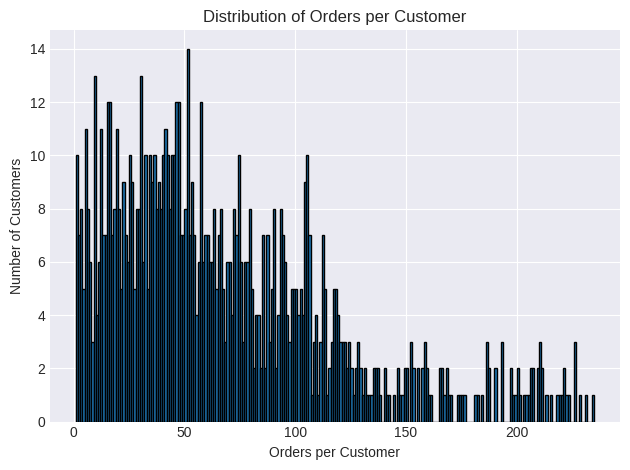

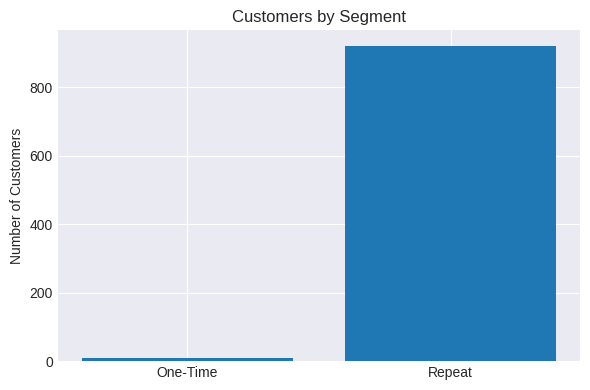

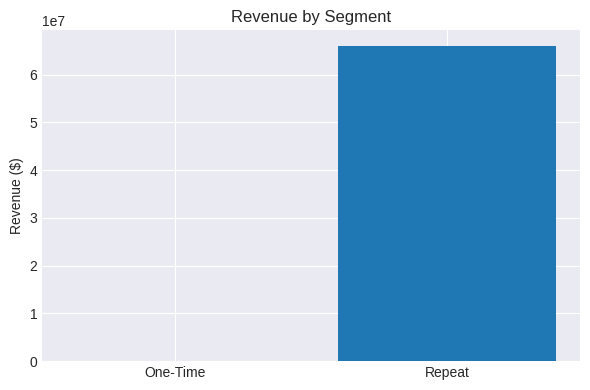

In [15]:
# ---- Visualization 1: Distribution of orders per customer (histogram) ----
import polars as pl # Import polars

# Check if cust_orders is defined, if not, create it
if 'cust_orders' not in locals():
    if 'orders' not in locals():
        orders = pl.read_csv('https://raw.githubusercontent.com/Masters-in-Management-2023-2024/final-project-jaffle-shop-grey-11/refs/heads/main/Orders.csv')
    # Clean orders data and calculate customer order frequency
    orders_clean_q4 = (
        orders.with_columns([
            pl.col("ordered_at").cast(pl.Datetime).alias("ts"),
            pl.col("order_total").cast(pl.Utf8).str.replace_all(r"[^0-9.\-]", "").cast(pl.Float64).alias("order_total_num")
        ])
        .drop_nulls(["order_total_num"])
    )
    cust_orders = (
        orders_clean_q4
        .group_by("customer")
        .agg([
            pl.len().alias("order_count"),
            pl.col("order_total_num").sum().alias("revenue")
        ])
    )

max_orders = int(cust_orders["order_count"].max())
bins = range(1, max_orders + 2) if max_orders >= 5 else 10
plt.hist(cust_orders["order_count"], bins=bins, edgecolor="black")
plt.title("Distribution of Orders per Customer")
plt.xlabel("Orders per Customer")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

# ---- Visualization 2: # Customers by segment ----
# Define one_time_customers and repeat_customers
one_time_customers = cust_orders.filter(pl.col("order_count") == 1).height
repeat_customers = cust_orders.filter(pl.col("order_count") > 1).height
total_customers = cust_orders.height
pct_one_time = one_time_customers / total_customers
pct_repeat = repeat_customers / total_customers

plt.figure(figsize=(6,4))
plt.bar(["One-Time", "Repeat"], [one_time_customers, repeat_customers])
plt.title("Customers by Segment")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

# ---- Visualization 3: Revenue by segment ----
# Define rev_one_time and rev_repeat
rev_one_time = cust_orders.filter(pl.col("order_count") == 1)["revenue"].sum()
rev_repeat = cust_orders.filter(pl.col("order_count") > 1)["revenue"].sum()

plt.figure(figsize=(6,4))
plt.bar(["One-Time", "Repeat"], [rev_one_time, rev_repeat])
plt.title("Revenue by Segment")
plt.ylabel("Revenue ($)")
plt.tight_layout()
plt.show()

In [ ]:
orders["customer"].n_unique()

930

## Executive Summary
The above analysis shows a real clear pattern. Weekdays performance are much better and consistently perform better than the weekends across locations. Even though weekends generate meaningful sales the weekdays have a much stronger revenue suggesting that our stores are much closer to the work spot than a brunch spot. Our recommendation would be to look at and expand in neighborhoods closely positioned in business districts. While doing this we also recommend scheduling more resources during weekdays so we can maximize the peak efficiency so we can capture peak demand. We also propose to target offices with promotional ads to make our store known and increase the demand during the week.

Low Margin product
The second analysis comes from the product margins that reveal that the bottom Stock Keeping Unit like Chai and mighty, the Krautback and the doctor stew are consistently delivering lower portability compared to the rest of the products. While Revenue for these products might be high due to the sales volume the profit margin is mostly around 10%. This shows that even though these items may be less profitable than mothers individually some of them actually act as traffic drivers which keep sustaining broader sales. Our recommendation is when going forward our company should take a selective approach by maintaining this low margin product which maintains high volume but reprice them to achieve a 15% margin (Vanilla Ice and Flame Impala). Products that show both low margins and low revenue contribution (Chai and Mighty, Doctor Stew and the Krautback) should be discontinued to reduce the complexity of the menu and so we can focus our resources on other products. This targeted strategy will improve the profitability and position our company for a stronger margin overall.

Customer Behavior
The third analysis clearly shows that the business almost entirely relies on repeat customers for revenue with one time customer representing 1.1% of the sales. This shows that our customers are loyal but also shows an untapped market. This shows a steady revenue but no pipeline and a weakness where we can grow. To sustain our companies long term growth we should invest in new customer acquisition by adding campaigns to broaden the base of new buyers. Then once we have completed that make sure we keep those one time customers through targeted follow ups, loyalty programs and personalized one time offers. Another option could be to leverage our active customer base and use them as brand ambassadors making a special promotion where if a loyal customer comes back with a new user they get a free coffee. This will help improve our pipeline and get us new customers

### Key Findings:
1.Weekday Strength vs. Weekend Weakness
Revenue performance is consistently stronger during weekdays than weekends, indicating stores are positioned more as workplace lunch/dinner spots rather than weekend brunch destinations.

2.Low-Margin Product Drag
Several products (e.g., Chai and Mighty, Doctor Stew, Krautback) contribute little to profit, with margins around 10% or lower. Some high-volume/low-margin products act as traffic drivers, while others add complexity without meaningful revenue contribution.

3.Heavy Dependence on Repeat Customers
The business relies almost entirely on repeat customers (98%+ of sales), leaving little contribution from first-time buyers. While this highlights loyalty, it exposes a growth gap in attracting and retaining new customers.

### Strategic Recommendations:
1.Expand Near Business Hubs & Optimize Weekday Ops
2.Reprice or Remove Low-Margin SKUs
3.Boost New Customer Acquisition